# Calculate CF (like Arousal)

## Import package

In [276]:
# pip install pydub
import numpy as np
import pandas as pd
from pydub import AudioSegment
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')
import os

## Setting

In [277]:
wav_file_name = "C001L_001"
voice_file_path = "voice_data/UUDB/"
output_path = "voice_results/cf_" + wav_file_name + "/"

In [278]:
# make a output_file
pwd = os.getcwd()
print(pwd)
if (os.path.isdir(pwd + "/" + output_path) == True):
    v = len([name for name in os.listdir(pwd + "/" + output_path) if os.path.isfile(os.path.join(pwd + "/" + output_path, name))])
    version = v+1
    print("version :", version)
else:
    os.mkdir(output_path)
    version = 1
    print("version :", version)

/home/harada/デスクトップ/IEMOCAP_NN
version : 1


## Import data

In [279]:
wav_file = AudioSegment.from_wav(voice_file_path + wav_file_name + ".wav")

In [280]:
print("Duration seconds: ", wav_file.duration_seconds)
print("Duration miuntes: ", wav_file.duration_seconds/60)
print("Frame rate      : ", wav_file.frame_rate)
print("Channels        : ", wav_file.channels)

Duration seconds:  0.5590022675736962
Duration miuntes:  0.009316704459561603
Frame rate      :  11025
Channels        :  1


In [281]:
wav_array = np.array(wav_file.get_array_of_samples())
print("dtype: ", wav_array.dtype)
print("size : ", wav_array.size)

dtype:  int16
size :  6163


In [282]:
x_t = wav_array

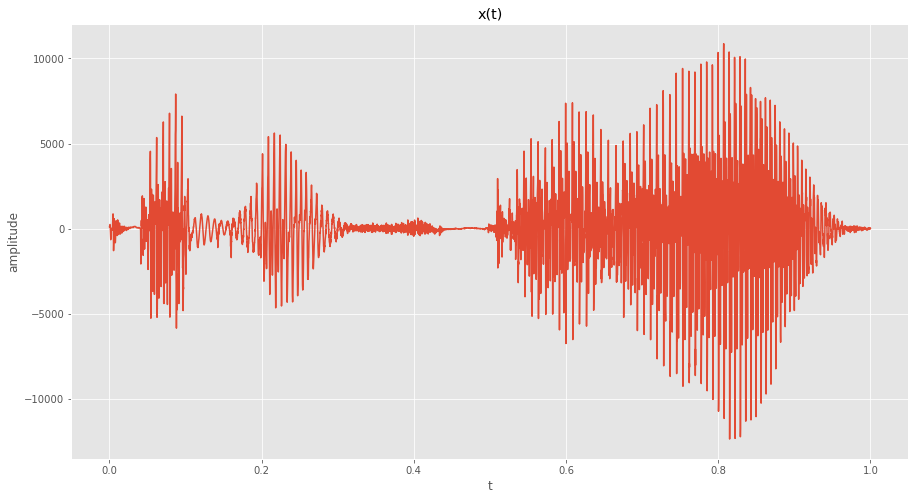

In [283]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

t = np.linspace(0,1,x_t.size)
ax.plot(t, x_t)
plt.title("x(t)")
plt.xlabel("t")
plt.ylabel("amplitude")
plt.show()

## Data processing

In [284]:
# x(t)
x_t

array([116, 161, 177, ..., -11,  15,  19], dtype=int16)

In [285]:
# x(t)_bar = mean{x(t)}
x_t_bar = np.mean(x_t)
x_t_bar

0.6008437449294175

In [286]:
# y(t) = x(t) - x(t)_bar
y_t = x_t - x_t_bar
y_t

array([115.39915626, 160.39915626, 176.39915626, ..., -11.60084374,
        14.39915626,  18.39915626])

In [287]:
# y(t).mean =~ 0
np.mean(y_t)

4.6633186071758126e-14

In [288]:
# max{y(t)}, min{y(t)}
y_t_max = np.max(y_t)
y_t_min = np.min(y_t)
print(" max{y(t)} = ",y_t_max,"\n","min{y(t)} = ", y_t_min)

 max{y(t)} =  10863.399156255071 
 min{y(t)} =  -12347.600843744929


In [289]:
# z(t) = y(t) / ( max{y(t)} - min{y(t)} )
z_t = y_t / (y_t_max - y_t_min)
z_t

array([ 0.00497174,  0.00691048,  0.00759981, ..., -0.0004998 ,
        0.00062036,  0.00079269])

In [290]:
# z(t) =~ 0
np.mean(z_t)

1.1078811620062815e-18

In [291]:
# max{z(t)} - min{z(t)} = 1.0
np.max(z_t) - np.min(z_t)

1.0

#### Check the graph

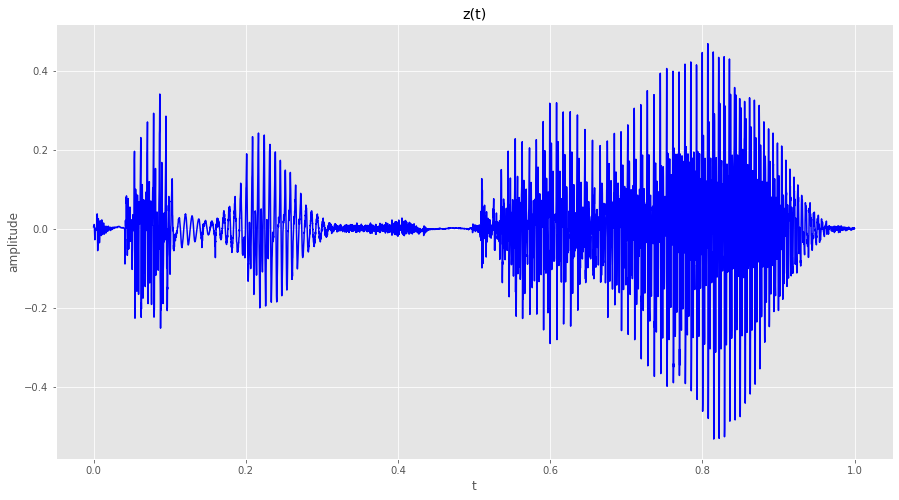

In [292]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

t = np.linspace(0,1,z_t.size)
ax.plot(t, z_t, color = 'b')
plt.title("z(t)")
plt.xlabel("t")
plt.ylabel("amplitude")
plt.show()

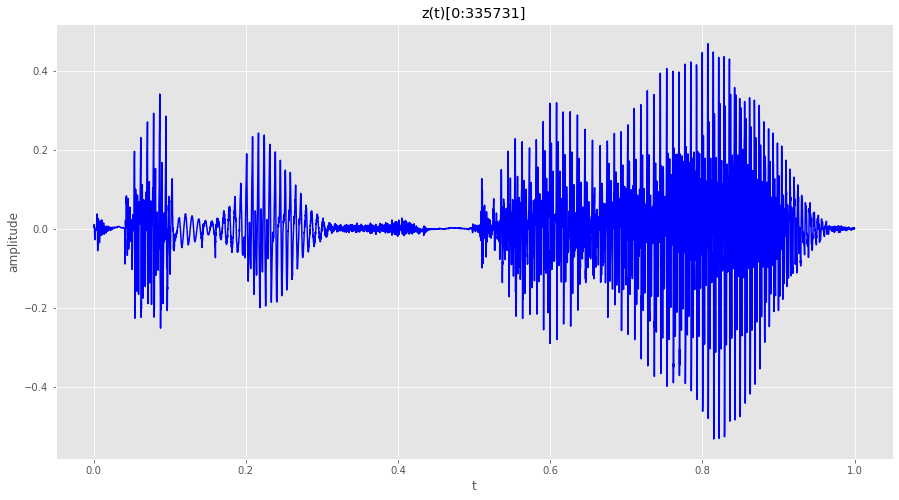

In [293]:
dd = 100
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

t = np.linspace(0,1,z_t.size)
d = int(33573154/dd)
ax.plot(t[0:d], z_t[0:d], color = 'b')
title = "z(t)[0:"+str(d)+"]"
plt.title(title)
plt.xlabel("t")
plt.ylabel("amplitude")
plt.show()

## Calculate CF
$$
    v(t) = z(t+1) - z(t) \\
    a(t) = \frac{|v(t+1)| + |v(t)|}{2 |v(t+1)| |v(t)|} [ v(t+1) - v(t) ] \\
    CF(t) = 
        \begin{cases}
            -a(t) \quad if z(t) < 0 \\
            a(t) \quad else \\
        \end{cases}
    CF = \frac{\sum_{t_1}^{N} a(t)}{N}
$$

In [294]:
# z(t)
z_t

array([ 0.00497174,  0.00691048,  0.00759981, ..., -0.0004998 ,
        0.00062036,  0.00079269])

In [295]:
# step1. v(t)
v_t = np.diff(z_t)
v_t

array([ 0.00193874,  0.00068933,  0.00163715, ..., -0.00120632,
        0.00112016,  0.00017233])

In [296]:
# step1.5. [v_t[i+1] - v_t[i]]
a_t_normal = np.diff(v_t)
a_t_normal

array([-0.00124941,  0.00094783, -0.00030158, ..., -0.00073241,
        0.00232648, -0.00094783])

In [297]:
print(" z_t.size = ",z_t.size,"\n","v_t.size = ",v_t.size,"\n","a_t_normal.size = ", a_t_normal.size)

 z_t.size =  6163 
 v_t.size =  6162 
 a_t_normal.size =  6161


In [298]:
# step2. a(t)
a_t = []
#a_t_cmp = []
for i in range(v_t.size -1):
    if i==19999:
        print("Ex i = ",i)
        print(" abs(v_t[",i+1,"])= ", abs(v_t[i+1]))
        print(" abs(v_t[",i,"]))= ", abs(v_t[i]))
        print(" (abs(v_t[",i+1,"]) + abs(v_t[",i,"])) / (2 * abs(v_t[",i+1,"]) * abs(v_t[",i,"]))= ", (abs(v_t[i+1]) + abs(v_t[i])) / (2 * abs(v_t[i+1]) * abs(v_t[i])))
        print("-----------------------------------------")
        print(" (v_t[",i+1,"])= ", (v_t[i+1]))
        print(" (v_t[",i,"]))= ", (v_t[i]))
        print(" (v_t[",i+1,"] - v_t[",i,"])= ", (v_t[i+1] - v_t[i]))
        print("-----------------------------------------")
        print(" a_t = ", ((abs(v_t[i+1]) + abs(v_t[i])) / (2 * abs(v_t[i+1]) * abs(v_t[i]))) * (v_t[i+1] - v_t[i]))
        print("-----------------------------------------")
    
    if (2 * abs(v_t[i+1]) * abs(v_t[i]))==0:
        #a_t.append(np.nan)
        a_t.append(np.nan)
    else:
        a_coeff = ((abs(v_t[i+1]) + abs(v_t[i])) / (2 * abs(v_t[i+1]) * abs(v_t[i])))
        #a_t.append(a_coeff * (v_t[i+1] - v_t[i]))
        a_t.append(a_coeff * a_t_normal[i])
a_t = np.array(a_t)
a_t

array([-1.22847222,  0.97697368, -0.20500849, ..., -1.0762987 ,
        2.00274725, -3.17307692])

In [299]:
print(" z_t.size = ",z_t.size,"\n","v_t.size = ",v_t.size,"\n","a_t.size = ", a_t.size)

 z_t.size =  6163 
 v_t.size =  6162 
 a_t.size =  6161


In [300]:
# step2.5. CF(t)
cf_t = np.where(z_t[0:a_t.size] > 0, -1 * a_t, a_t)
cf_t

array([ 1.22847222, -0.97697368,  0.20500849, ...,  1.0762987 ,
       -2.00274725, -3.17307692])

In [301]:
print(" cf_t.size = ",cf_t.size)

 cf_t.size =  6161


In [302]:
# step3. CF 
## exclusion nan
cf = np.nanmean(cf_t)
cf

0.5674560878140205

## Export value of CF

In [303]:
cf_list = []
cf_list.append(cf)

In [304]:
cf_df = pd.DataFrame(cf_list)

In [305]:
cf_df.to_csv(output_path + "cf_{0}_v{1}.csv".format(wav_file_name, str(version)))

In [306]:
!sleep 1;notify-send "Finished output!!"